# Алгоритм

In [1]:
# перед запуском алгоритма загрузите пожалуйста этот пакет
#!pip install gensim 

# импортируем нужные библиотеки
from copy import deepcopy
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec # библотека для обработки естественного языка

# основная функция. первый аргумент - директория файла, второй - размер бокса (кол-во алмазов в одном боксе)
def split(file_path, batch_size):
    
    # функция для кодирования значений признака Вес по трем категориям
    def encode_weight(x):
        x = float(x)
        if x < 300:
            return '0_300'
        if x < 500:
            return '300_500'
        return '500_1000'
    
    # функция для кодирования значений признака Стоимость по трем категориям
    def encode_cost(x):
        x = float(x)
        if x < 2.6:
            return '0_3'
        if x < 5:
            return '3_5'
        return '5_10'
    
    # функция которая берет векторизованные признаки
    def get_vector(e):
        for elem in variants:
            if elem['diamond'] == e:
                return elem['vector']
            
    # читаем данные для модели word2vec
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except:
        df = pd.read_csv(file_path)
    
    df = df.drop(['Номер', ], axis=1)
    
    encoders = {'Форма': ['Звезда', 'Круг', 'Квадрат', 'Треугольник'], 'Цвет': ['Cиний', 'Красный', 'Зелёный', 'Жёлтый'], 'Размер': ['Большой', 'Средний', 'Малый'], 'Флуоресценция': ['Светится', 'Не светится'], 'Вес': ['300_500', '500_1000', '0_300'], 'Стоимость': ['3_5', '5_10', '0_3']}
    
    # применим функции кодирования
    df['Вес'] = df['Вес'].apply(encode_weight)
    df['Стоимость'] = df['Стоимость'].apply(encode_cost)
    
    # создадим numpy array матрицу, чтобы модель быстрее обучилась
    data = [list(x) for x in np.array(df)]
    
    # обучим модель
    model = Word2Vec(vector_size=16, min_count=1) # vector_size - размер векторного представления слова, min_count - игнорировать все слова с частотой встречаемости меньше, чем это значение
    model.build_vocab(data)
    model.train(data, total_examples=model.corpus_count, epochs=100, report_delay=1)

    # в списке variants под ключом diamond будут храниться эмбединги алмаза, а под vector его вектор
    variants = []
    for a in encoders['Форма']:
        for b in encoders['Цвет']:
            for c in encoders['Размер']:
                for d in encoders['Флуоресценция']:
                    for e in encoders['Вес']:
                        for f in encoders['Стоимость']:
                            variants.append({'diamond': [a, b, c, d, e, f], 'vector': list((model.wv[a] +model.wv[b] + model.wv[c] + model.wv[d] + model.wv[e] + model.wv[f]).astype(float))})

    # читаем файлы
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except:
        df = pd.read_csv(file_path) 
    
    # создаем копию основной таблицы
    embeddings = deepcopy(df)
    embeddings['Вес'] = embeddings['Вес'].apply(encode_weight)
    embeddings['Стоимость'] = embeddings['Стоимость'].apply(encode_cost)
    
    # создаем словарь где каждому номеру алмаза соответствует его векторизированные признаки
    id_vector = {i: get_vector(list(embeddings[embeddings['Номер'] == i].iloc[0][1:])) for i in embeddings['Номер']}
    
    batchs = []
    
    # сортируем по расстоянию от первого обьекта. первые (len(df) // batch_size) добавляем в список batchs. 
    # в итоге в batchs будут хранится списки номеров похожих алмазов
    for i in range(batch_size):
        diamond = list(embeddings.iloc[0])
        distance = cosine_similarity([id_vector[diamond[0]]],
                                     [id_vector[id_] for id_ in embeddings['Номер']])
        embeddings['distance'] = distance[0].reshape(-1, 1)
        embeddings.sort_values(by=['distance'], inplace=True)
        embeddings = embeddings.iloc[::-1]
        embeddings.reset_index(inplace=True, drop=True)
        batchs.append([])
        cache = []
        for j in range(len(df) // batch_size):
            batchs[i].append(embeddings.iloc[j]['Номер'])
            cache.append(j)
        embeddings.drop(cache, axis=0, inplace=True)
        embeddings.reset_index(inplace=True, drop=True)
    
    # чтобы в каждом боксе были разнообразные алмазы (а в списке batchs хранятся списки номеров ПОХОЖИХ алмазов)
    # проходимся по циклу batchs и в списке batch передаем i-ые индексы всех подсписков batchs
    # сохраняем боксы каждый в отдельный файл
    for i in range(len(df) // batch_size):
        batch = [batchs[j][i] for j in range(batch_size)]
        df[df['Номер'].isin(batch)].to_excel(f'box_{i+1}.xls', index=False)
        
    # в итоге алгоритм создал для каждого бокса отдельный excel файл
    
# как вызвать функцию
# split(путь к файлу, количество алмазов в одном боксе)

# Тот же алгоритм, но возвращает таблицу

In [2]:
def split_into_boxes_df(file_path, batch_size):
    
    def encode_weight(x):
        x = float(x)
        if x < 300:
            return '0_300'
        if x < 500:
            return '300_500'
        return '500_1000'
    
    def encode_cost(x):
        x = float(x)
        if x < 2.6:
            return '0_3'
        if x < 5:
            return '3_5'
        return '5_10'
    
    def get_vector(e):
        for elem in variants:
            if elem['diamond'] == e:
                return elem['vector']
            
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except:
        df = pd.read_csv(file_path)
    
    df = df.drop(['Номер', ], axis=1)
    
    encoders = {'Форма': ['Звезда', 'Круг', 'Квадрат', 'Треугольник'], 'Цвет': ['Cиний', 'Красный', 'Зелёный', 'Жёлтый'], 'Размер': ['Большой', 'Средний', 'Малый'], 'Флуоресценция': ['Светится', 'Не светится'], 'Вес': ['300_500', '500_1000', '0_300'], 'Стоимость': ['3_5', '5_10', '0_3']}
    
    df['Вес'] = df['Вес'].apply(encode_weight)
    df['Стоимость'] = df['Стоимость'].apply(encode_cost)
    
    data = [list(x) for x in np.array(df)]
    
    model = Word2Vec(vector_size=16, min_count=1) 
    model.build_vocab(data)
    model.train(data, total_examples=model.corpus_count, epochs=100, report_delay=1)

    variants = []
    for a in encoders['Форма']:
        for b in encoders['Цвет']:
            for c in encoders['Размер']:
                for d in encoders['Флуоресценция']:
                    for e in encoders['Вес']:
                        for f in encoders['Стоимость']:
                            variants.append({'diamond': [a, b, c, d, e, f], 'vector': list((model.wv[a] +model.wv[b] + model.wv[c] + model.wv[d] + model.wv[e] + model.wv[f]).astype(float))})

    try:
        df = pd.read_excel(file_path, engine='openpyxl')
    except:
        df = pd.read_csv(file_path) 

    embeddings = deepcopy(df)
    embeddings['Вес'] = embeddings['Вес'].apply(encode_weight)
    embeddings['Стоимость'] = embeddings['Стоимость'].apply(encode_cost)

    id_vector = {i: get_vector(list(embeddings[embeddings['Номер'] == i].iloc[0][1:])) for i in embeddings['Номер']}
    
    batchs = []
    
    for i in range(batch_size):
        diamond = list(embeddings.iloc[0])
        distance = cosine_similarity([id_vector[diamond[0]]],
                                     [id_vector[id_] for id_ in embeddings['Номер']])
        embeddings['distance'] = distance[0].reshape(-1, 1)
        embeddings.sort_values(by=['distance'], inplace=True)
        embeddings = embeddings.iloc[::-1]
        embeddings.reset_index(inplace=True, drop=True)
        batchs.append([])
        cache = []
        for j in range(len(df) // batch_size):
            batchs[i].append(embeddings.iloc[j]['Номер'])
            cache.append(j)
        embeddings.drop(cache, axis=0, inplace=True)
        embeddings.reset_index(inplace=True, drop=True)
    
    for i in range(len(df) // batch_size):
        batch = [batchs[j][i] for j in range(batch_size)]
        df.loc[df['Номер'].isin(batch), 'Бокс'] = i+1
        
    return df

# Вызов функции

In [3]:
%%time

split('data.xlsm', 100)

Wall time: 10.9 s


# Чтение файлов

In [4]:
box_1 = pd.read_excel('box_1.xls')
box_2 = pd.read_excel('box_2.xls')
box_3 = pd.read_excel('box_3.xls')
box_4 = pd.read_excel('box_4.xls')
box_5 = pd.read_excel('box_5.xls')
box_6 = pd.read_excel('box_6.xls')
box_7 = pd.read_excel('box_7.xls')
box_8 = pd.read_excel('box_8.xls')
box_9 = pd.read_excel('box_9.xls')
box_10 = pd.read_excel('box_10.xls')

In [5]:
box_1.head()

,Номер,Форма,Цвет,Размер,Флуоресценция,Вес,Стоимость
0,1,Квадрат,Cиний,Средний,Светится,440,3
1,4,Круг,Cиний,Малый,Не светится,183,2
2,40,Треугольник,Красный,Средний,Светится,321,5
3,42,Квадрат,Cиний,Малый,Светится,242,3
4,47,Звезда,Красный,Малый,Светится,59,1


# Проверяем распределение суммарной стоимости

In [6]:
prices = [box_1['Стоимость'].sum(), box_2['Стоимость'].sum(), box_3['Стоимость'].sum(), box_4['Стоимость'].sum(),
          box_5['Стоимость'].sum(), box_6['Стоимость'].sum(), box_7['Стоимость'].sum(), box_8['Стоимость'].sum(),
          box_9['Стоимость'].sum(), box_10['Стоимость'].sum()]

box_names = ['Бокс 1', 'Бокс 2', 'Бокс 3', 'Бокс 4', 'Бокс 5', 'Бокс 6', 'Бокс 7', 'Бокс 8', 'Бокс 9', 'Бокс 10']

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")
sns.set(rc={'figure.figsize':(12,8)})
sns.set_context("paper", font_scale=1.5)    

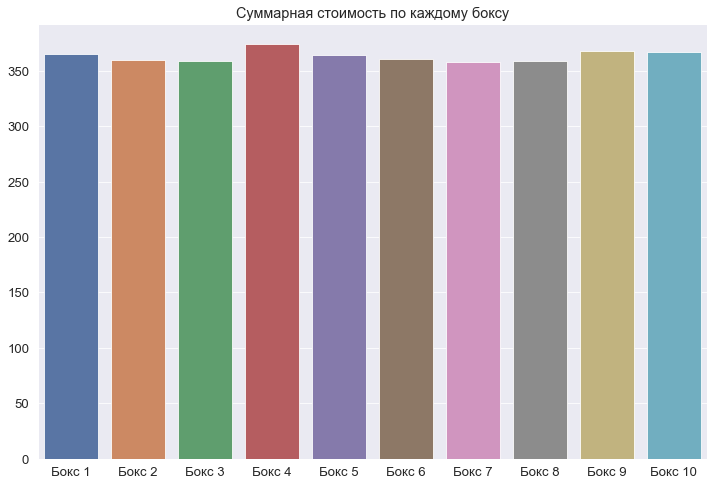

In [8]:
sns.barplot(x=box_names, y=prices).set_title("Суммарная стоимость по каждому боксу");

# Проверяем распределение суммарных весов

In [9]:
weights = [box_1['Вес'].sum(), box_2['Вес'].sum(), box_3['Вес'].sum(), box_4['Вес'].sum(),
          box_5['Вес'].sum(), box_6['Вес'].sum(), box_7['Вес'].sum(), box_8['Вес'].sum(),
          box_9['Вес'].sum(), box_10['Вес'].sum()]

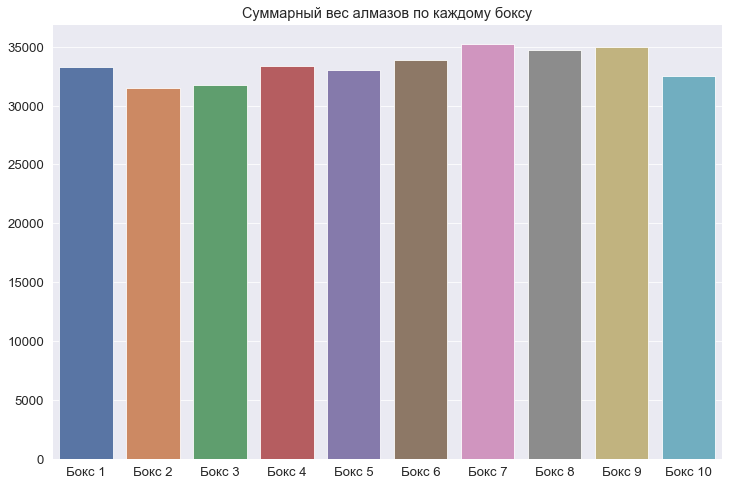

In [10]:
sns.barplot(x=box_names, y=weights).set_title("Суммарный вес алмазов по каждому боксу");

# Проверяем на "одинаковость" боксов

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
df = split_into_boxes_df('data.xlsm', 100)

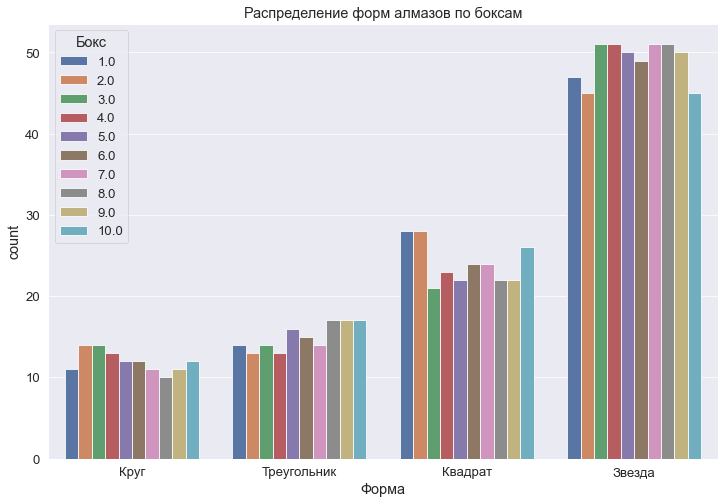

In [13]:
sns.countplot(x='Форма', data=df, order=['Круг', 'Треугольник', 'Квадрат', 'Звезда'], hue='Бокс')\
             .set_title('Распределение форм алмазов по боксам');

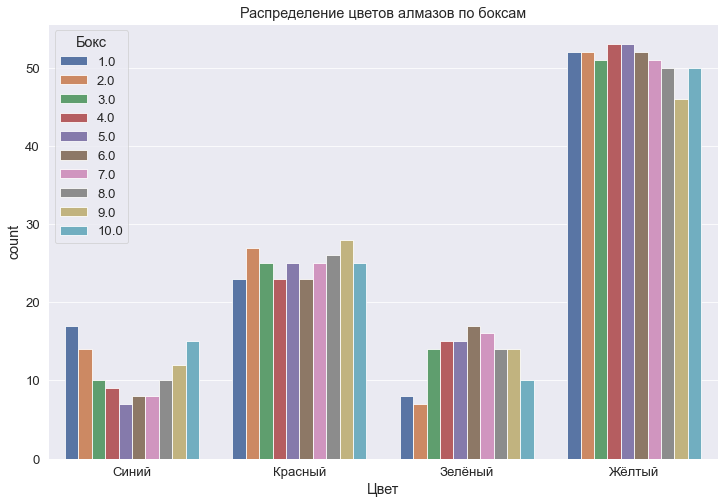

In [14]:
sns.countplot(x='Цвет', data=df, hue='Бокс')\
             .set_title('Распределение цветов алмазов по боксам');

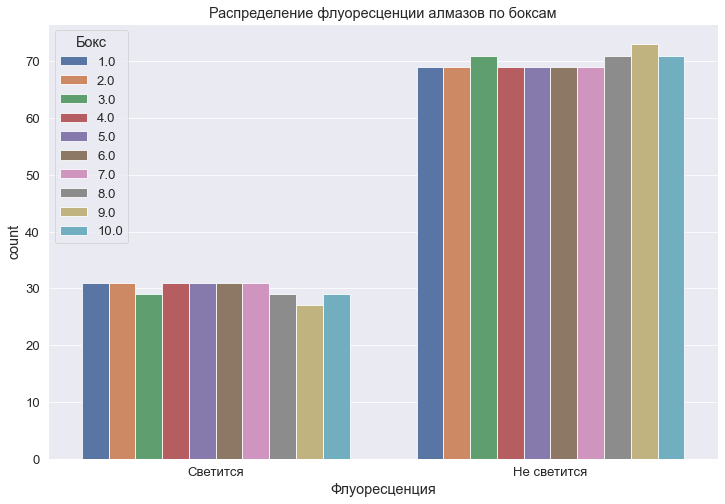

In [15]:
sns.countplot(x='Флуоресценция', data=df, hue='Бокс')\
             .set_title('Распределение флуоресценции алмазов по боксам');